In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

In [ ]:
# 위의 코드가 작동하지 않을 때 대안 코드 1 실행
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()
#NameError: name 'Tagger' is not defined 오류 발생 시 런타임을 재실행 해주세요.

In [ ]:
# 한글 자모 단위 처리 패키지 설치
!pip install hgtk

In [ ]:
# fasttext 설치
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!make
!pip install .

In [ ]:
#hgtk 설치
!pip install hgtk

## 1. 데이터 로드

In [ ]:
import re
import pandas as pd
import urllib.request
from tqdm import tqdm
import hgtk

In [ ]:
# 네이버 쇼핑 리뷰
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7c3431383c70>)

In [ ]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [ ]:
total_data.head()

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


## 2. hgtk 튜토리얼



word embedding이 단어 단위의 임베딩이었다면, character embedding은 문자 단위의 임베딩입니다. 한국어를 character embedding할 수 있는 것이 바로 자음 모음 분리기 hgtk입니다.

 영어는 하나의 알파벳(52자)를 기준으로 character embedding을 하지만, 한국어에서 하나의 음절별로 character embedding을 하면 11172개의 음절이 있기 때문에 계산량이 너무 많습니다. 따라서 그보다 작은 단위인 자음,모음으로 분리하는 것입니다.

 >참고 repo: https://github.com/bluedisk/hangul-toolkit

In [ ]:
# 한글인지 체크
print(hgtk.checker.is_hangul('ㄱ'))
print(hgtk.checker.is_hangul('12'))
print(hgtk.checker.is_hangul('a'))

True
False
False


In [ ]:
# 음절을 초성, 중성, 종성으로 분해
print(hgtk.letter.decompose('남'))
# 초성, 중성, 종성을 하나의 음절로 결합
print(hgtk.letter.compose('ㄴ', 'ㅏ', 'ㅁ'))

('ㄴ', 'ㅏ', 'ㅁ')
남


In [ ]:
# 결합할 수 없는 상황에서는 에러 발생
try:
  hgtk.letter.compose('ㄴ', 'ㅁ', 'ㅁ') # 중성이 없는 경우
except:
  print('에러 발생')

에러 발생


## 3. 데이터 전처리

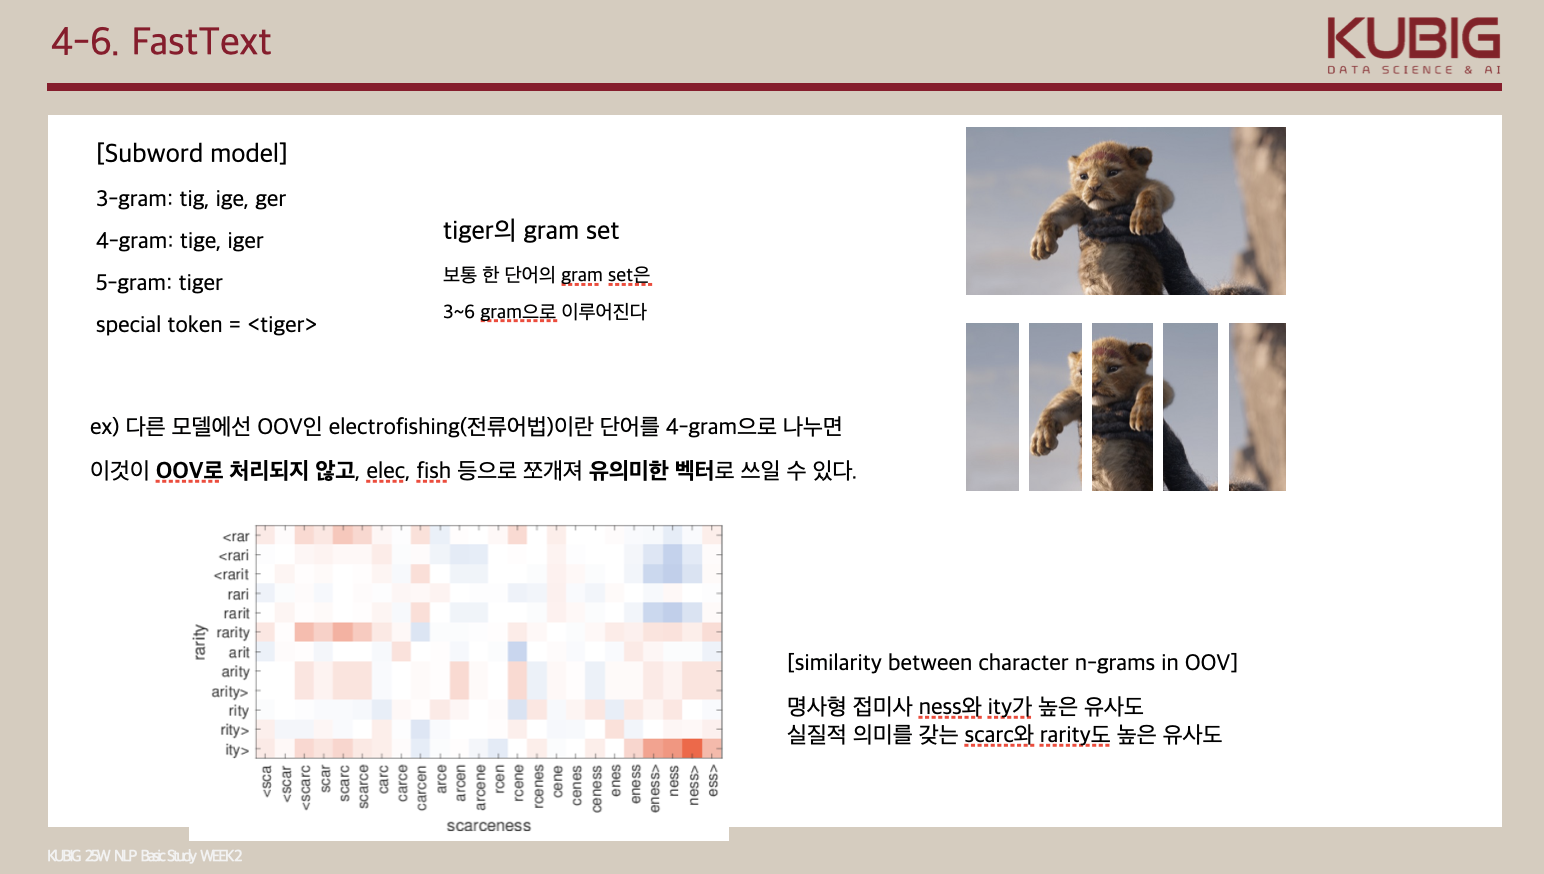

In [ ]:
def word_to_jamo(token):
  def to_special_token(jamo): # 경우에 따라 초, 중, 종성이 다 있는 게 아닌 경우도 있다. 이 경우 -를 반환해주는 함수
    if not jamo:
      return '-'
    else:
      return jamo

  decomposed_token = ''
  for char in token:
    try:
      # char(음절)을 초성, 중성, 종성으로 분리
      cho, jung, jong = hgtk.letter.decompose(char)

      # 자모가 빈 문자일 경우 특수문자 -로 대체
      cho = to_special_token(cho)
      jung = to_special_token(jung)
      jong = to_special_token(jong)
      decomposed_token = decomposed_token + cho + jung + jong

    # 만약 char(음절)이 한글이 아닐 경우 자모를 나누지 않고 추가
    except Exception as exception:
      if type(exception).__name__ == 'NotHangulException':
        decomposed_token += char

  # 단어 토큰의 자모 단위 분리 결과를 추가
  return decomposed_token

In [ ]:
print(word_to_jamo('남동생'))
print(word_to_jamo('야구')) # 야구의 경우 종성이 없으므로 종성 부분을 -로 반환

In [ ]:
print(mecab.morphs('선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다.'))

In [ ]:
# mecab으로 형태소를 분리해주고 그 형태소마다 각각 자음모음을 분리해주는 함수
def tokenize_by_jamo(s):
    return [word_to_jamo(token) for token in mecab.morphs(s)]

In [ ]:
print(tokenize_by_jamo('선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다.'))

In [ ]:
# 리뷰 데이터의 reviews 컬럼만을 가져와서 자모 분리
tokenized_data = []

for sample in tqdm(total_data['reviews'].to_numpy()):
    tokenzied_sample = tokenize_by_jamo(sample) # 자소 단위 토큰화
    tokenized_data.append(tokenzied_sample)

In [ ]:
print(len(tokenized_data))
print("전처리 전:", total_data['reviews'][1])
print("전처리 후:", tokenized_data[1])

단어를 자모 분리한 것을 역으로 하여 자모 상태를 단어로 다시 결합시키는 함수도 정의해봅시다. 이는 단어의 코사인 유사도를 평가할 때 자모 분리가 된 상태가 아니라 단어 상태로 편리하게 보기 위함입니다.

In [ ]:
def jamo_to_word(jamo_sequence):
  tokenized_jamo = []
  index = 0

  # 1. 초기 입력
  # jamo_sequence = 'ㄴㅏㅁㄷㅗㅇㅅㅐㅇ'

  while index < len(jamo_sequence):
    # 문자가 한글(정상적인 자모)이 아닐 경우
    if not hgtk.checker.is_hangul(jamo_sequence[index]):
      tokenized_jamo.append(jamo_sequence[index])
      index = index + 1

    # 문자가 정상적인 자모라면 초성, 중성, 종성을 하나의 토큰으로 간주.
    else:
      tokenized_jamo.append(jamo_sequence[index:index + 3])
      index = index + 3

  # 2. 자모 단위 토큰화 완료
  # tokenized_jamo : ['ㄴㅏㅁ', 'ㄷㅗㅇ', 'ㅅㅐㅇ']

  word = ''
  try:
    for jamo in tokenized_jamo:

      # 초성, 중성, 종성의 묶음으로 추정되는 경우
      if len(jamo) == 3:
        if jamo[2] == "-":
          # 종성이 존재하지 않는 경우
          word = word + hgtk.letter.compose(jamo[0], jamo[1])
        else:
          # 종성이 존재하는 경우
          word = word + hgtk.letter.compose(jamo[0], jamo[1], jamo[2])
      # 한글이 아닌 경우
      else:
        word = word + jamo

  # 복원 중(hgtk.letter.compose) 에러 발생 시 초기 입력 리턴.
  # 복원이 불가능한 경우 예시) 'ㄴ!ㅁㄷㅗㅇㅅㅐㅇ'
  except Exception as exception:
    if type(exception).__name__ == 'NotHangulException':
      return jamo_sequence

  # 3. 단어로 복원 완료
  # word : '남동생'

  return word

## 4. FastText

In [ ]:
import fasttext

fasttext를 실행하기에 앞서 훈련 대상인 단어들을 txt 파일로 준비해둬야 합니다. 따라서 `tokenized_data.txt`라는 파일을 쓰기 모드(w)로 생성해주고 앞서 전처리한 `tokenized_data`를 입력해줍니다.

In [ ]:
with open('tokenized_data.txt', 'w') as out:
  for line in tqdm(tokenized_data, unit=' line'):
    out.write(' '.join(line) + '\n')

아래처럼 `train_unsupeviesd` 함수는 훈련을 시켜주는 함수입니다. 인자로 훈련할 단어가 담긴 txt 파일을 지정하고 model을 `cbow`나 `skipgram` 중에 하나를 고르면 됩니다.

In [ ]:
model = fasttext.train_unsupervised('tokenized_data.txt', model='cbow')

In [ ]:
model.save_model("fasttext.bin")

In [ ]:
model = fasttext.load_model("fasttext.bin")

In [ ]:
model[word_to_jamo('남동생')] # 'ㄴㅏㅁㄷㅗㅇㅅㅐㅇ'

`get_nearest_neighbors` 함수를 사용하여 '남동생'이라는 단어와 가장 유사도가 높은 단어들(자모 분리된 상태)을 k개만큼 출력해줍니다.

In [ ]:
model.get_nearest_neighbors(word_to_jamo('남동생'), k=10)

앞서 만든 `jamo_to_word`로 가독성이 좋게 출력해봅시다.

In [ ]:
def transform(word_sequence):
  return [(jamo_to_word(word), similarity) for (similarity, word) in word_sequence]

In [ ]:
print(transform(model.get_nearest_neighbors(word_to_jamo('남동생'), k=10)))
print(transform(model.get_nearest_neighbors(word_to_jamo('구매'), k=10)))
print(transform(model.get_nearest_neighbors(word_to_jamo('배달'), k=10)))

[('동생', 0.8782657980918884), ('남친', 0.8384388089179993), ('친구', 0.7675294280052185), ('남편', 0.7394404411315918), ('생일', 0.7371999621391296), ('남아', 0.722217857837677), ('난생', 0.7222176790237427), ('학생', 0.7160051465034485), ('조카', 0.7146549224853516), ('중학생', 0.7136911749839783)]
[('구매처', 0.8465819358825684), ('구입', 0.7902079820632935), ('주문', 0.7450608611106873), ('주문건', 0.6759369969367981), ('구명조끼', 0.6397345066070557), ('주문서', 0.6304130554199219), ('구메', 0.630149781703949), ('헤매', 0.6147991418838501), ('구매자', 0.5905541777610779), ('시커매', 0.5823047757148743)]
[('배송지', 0.8141838908195496), ('매달', 0.8095385432243347), ('깨달', 0.7954334616661072), ('운송장', 0.7500762343406677), ('택배', 0.7437101602554321), ('메달', 0.7312359809875488), ('송장', 0.7231783866882324), ('주소', 0.7205659747123718), ('백배', 0.7160210609436035), ('경비실', 0.7076795697212219)]


## 5. Word2Vec

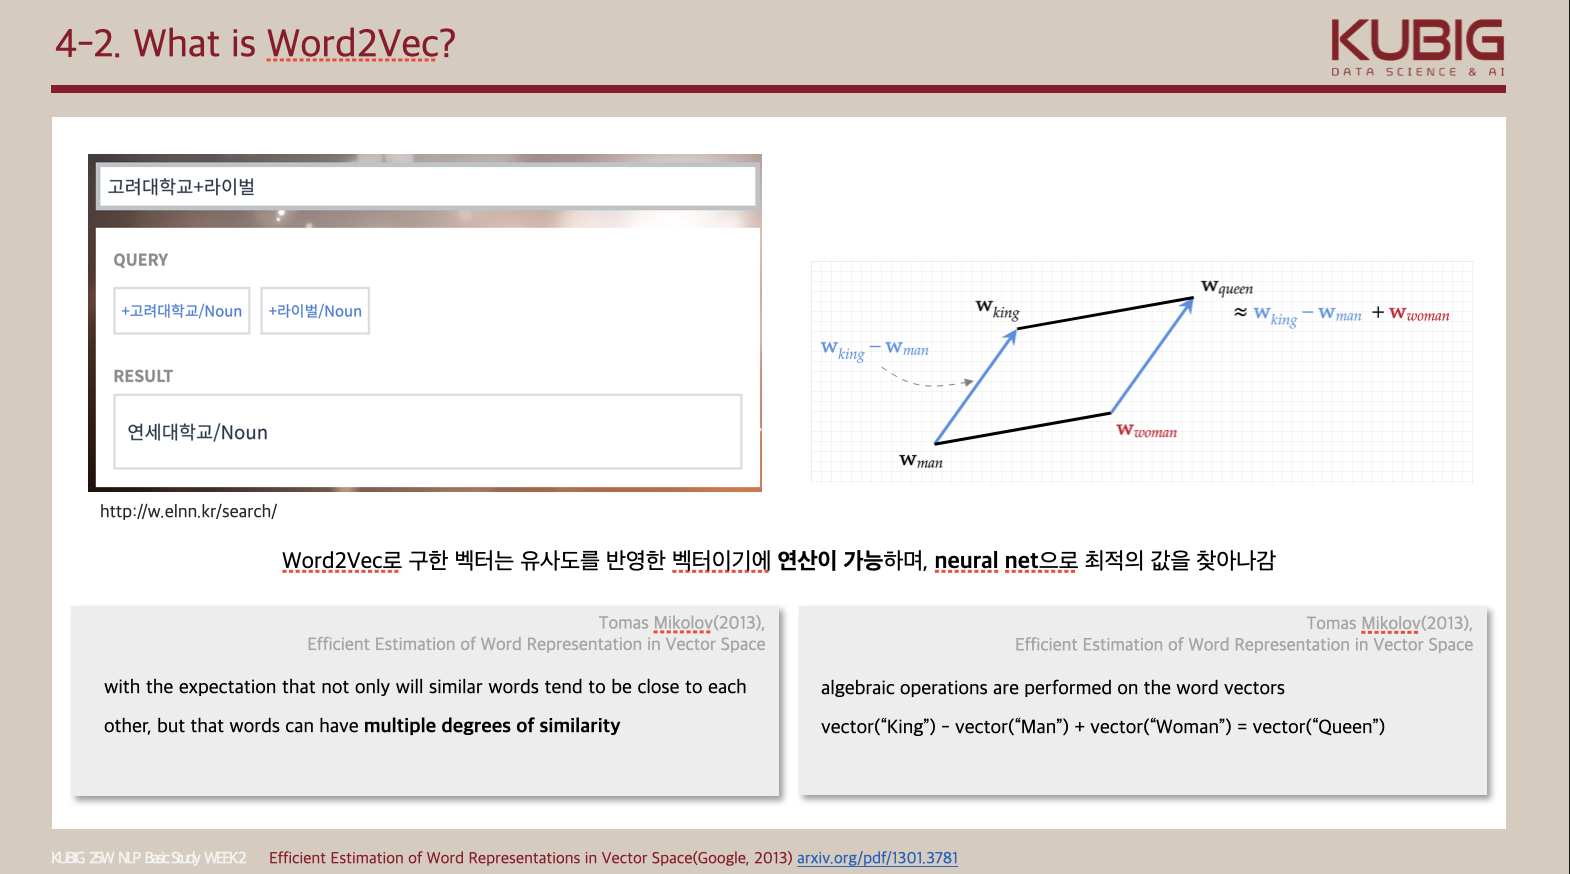
이제 word2vec를 사용하여 자모 단위로 분리하는 것이 아닌 단어 단위로 분리하여 임베딩 벡터를 생성해볼 것입니다.

In [ ]:
# 간단하게 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

tokenized_data2 = []
for sentence in tqdm(total_data['reviews'].to_list()):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data2.append(stopwords_removed_sentence)

In [ ]:
print("word2vec용 데이터:", tokenized_data2[0])
print("fasttext용 데이터:", tokenized_data[0])

In [ ]:
from gensim.models import Word2Vec

model2 = Word2Vec(sentences = tokenized_data2, vector_size = 1000, window = 5, min_count = 5, workers = 4, sg = 0)

In [ ]:
# 완성된 임베딩 매트릭스의 크기 확인
# 단어의 총 개수는 15005개이고 벡터 차원은 1000으로 축소되었다.
model2.wv.vectors.shape

## 6. FastText와 Word2Vec 결과 비교

### **Q1) 남동생과 주문 두 단어를 input으로 넣고 결과를 비교한 뒤 해석해보세요**

*(Hint: 유사도, 단어의 의미, 단어의 생김새 등을 고려해 볼 수 있습니다)*

In [ ]:
print("FastText 유사도:", transform(model.get_nearest_neighbors(word_to_jamo('남동생'), k=10)))
print("Word2Vec 유사도:", model2.wv.most_similar("남동생"))

In [ ]:
print("FastText 유사도:", transform(model.get_nearest_neighbors(word_to_jamo('주문'), k=10)))
print("Word2Vec 유사도:", model2.wv.most_similar("주문"))

**Your Inference:**

### **Q2) Fasttext가 Word2Vec보다 항상 성능이 나은지 다양한 input을 넣어서 시도해보세요**

In [ ]:
print("FastText 유사도:", transform(model.get_nearest_neighbors(word_to_jamo('<your word 1>'), k=10)))
print("Word2Vec 유사도:", model2.wv.most_similar("<your word 1>"))

In [ ]:
print("FastText 유사도:", transform(model.get_nearest_neighbors(word_to_jamo('<your word 2'), k=10)))
print("Word2Vec 유사도:", model2.wv.most_similar("<your word 2>"))

**Your Inference:**